# Segunda Prova de PAM
Carlos Eduardo Pereira da Costa - 20210026483

### Libs e variaveis de caminho

In [3]:
import glob
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

In [4]:
PASTA_SINAIS = 'Sinais'
CSV_PATH = 'sinais.csv'

# Pré-processamento

In [6]:
'''
Afim de reduzir a quantidade de colunas:
Com base no valor de max_frames, o algoritmo seleciona de maneira uniforme uma quantidade fixa de frames.
Com base em keypoint_ids, são selecionados quais keypoints são mantidos
Com base em features_mantidas, são escolhidas as features 
Os keypoints dos frames selecionados serão mantidos e utlizados para aliementar os modelos
'''

def processing(max_frames,keypoint_ids,features_mantidas,pasta):
    qtd_keypoints = len(keypoint_ids)
    
    features_por_keypoint = len(features_mantidas)
    
    # Caminho para a pasta de arquivos
    caminho_arquivos = os.path.join(pasta, '*.json')
    lista_arquivos_json = glob.glob(caminho_arquivos)
    
    dados_finais = []
    
    print(f"Iniciando processamento de {len(lista_arquivos_json)} arquivos JSON.")
    print(f"Estratégia: Reamostragem Uniforme para {max_frames} frames.")
    print(f"Features por sinal: {max_frames * qtd_keypoints * features_por_keypoint} colunas.")
    
    
    # Processamento dos arquivos
    for nome_arquivo in lista_arquivos_json:
        flat_data = {}
        
        '''
        Dicionário para armazenar a última coordenada válida para cada keypoint
        Vai ser usada para fazer padding caso o número de frames do video seja menor que o valor selecionado
        dessa forma eu busco mitigar o problema
        '''
        ultimo_kp_visto = {
            kp_id: {'x': 0.0, 'y': 0.0, 'z': 0.0}
            for kp_id in keypoint_ids
        }
        
        try:
            with open(nome_arquivo, 'r') as f:
                data = json.load(f)
    
            frames = data.get('frames', [])
            qtd_frames = len(frames) # Comprimento original do video
            
            file_name = os.path.basename(nome_arquivo)
            flat_data['file_name'] = file_name
    
            # Reamostragem de frames: Determina os índices dos frames a serem selecionados
            indices_selecionados = []
            if qtd_frames > max_frames:
                # Seleciona frames espaçados uniformemente
                step = int(qtd_frames / max_frames)
                
                indices_selecionados = [(i * step) for i in range(max_frames)]
            elif qtd_frames > 0:
                # Videos curtos ou iguais ao max_frames
               indices_selecionados = list(range(qtd_frames))
            # Se L=0, indices_selecionados é vazia e o loop de padding abaixo será totalmente padding.
    
            # Itera sobre o número fixo de frames
            for indice_frame in range(max_frames):
                
                # Checa se este frame deve ser preenchido (padding) ou se há dados reais
                is_padding_frame = indice_frame >= len(indices_selecionados)
                
                if not is_padding_frame:
                    # um frame real
                    indice_frame_original = indices_selecionados[indice_frame]
                    frame_data = frames[indice_frame_original]
                    keypoints = frame_data.get('keypoints', [])
                    
                    # Extração e atualização do padding
                    for kp_id in keypoint_ids:
                        prefixo = f'frame_{indice_frame}_kp_{kp_id}_'
                        
                        # Tenta encontrar o keypoint com o ID específico
                        kp_data = next((kp for kp in keypoints if kp['id'] == kp_id), None)
                        
                        if kp_data:
                            # Preenche com dados reais e atualiza o padding
                            for feature in features_mantidas:
                                value = kp_data.get(feature, 0.0)
                                flat_data[prefixo + feature] = value
                                ultimo_kp_visto[kp_id][feature] = value 
                        else:
                            # Keypoint ausente no frame real, usa padding.
                            for feature in features_mantidas:
                                locf_value = ultimo_kp_visto[kp_id][feature]
                                flat_data[prefixo + feature] = locf_value
                                
                else:
                    # É um sinal curto
                    for kp_id in keypoint_ids:
                        prefixo = f'frame_{indice_frame}_kp_{kp_id}_'
                        
                        # Usa padding para todos os keypoints
                        for feature in features_mantidas:
                            locf_value = ultimo_kp_visto[kp_id][feature]
                            flat_data[prefixo + feature] = locf_value
            
            dados_finais.append(flat_data)
            
        except Exception as e:
            print(f"Erro ao processar o arquivo {nome_arquivo}: {e}. O arquivo foi ignorado.")
            
            dados_finais.append(flat_data)
            
        except Exception as e:
            print(f"Erro ao processar o arquivo {nome_arquivo}: {e}. O arquivo foi ignorado.")
    
    # Cria o DataFrame final
    if dados_finais:
        df_final = pd.DataFrame(dados_finais)
        
        print("\nDataFrame final criado com sucesso!")
        
        num_colunas_features = max_frames * qtd_keypoints * features_por_keypoint
        
        print(f"Total de Linhas (Sinais): {df_final.shape[0]}")
        print(f"Total de Colunas (Features + Label): {df_final.shape[1]}")
        print(f"Colunas de Features: {num_colunas_features}")
    
        return df_final
    else:
        print("\nNenhum DataFrame foi criado. Verifique se os arquivos JSON estão no caminho informado e no formato correto.")

## Agregração de atributos

In [8]:
'''
Faz o match com o nome do arquivo da pasta com o do csv para pegar metadados importantes de cada video
Metadados selecionados: largura,altura sinal e interprete
'''
def merge(df):
    df_metadata = pd.read_csv(CSV_PATH)
    df_metadata['file_name'] = df_metadata['file_name'].str.strip()
    
    df_merged = df.copy()
    df_merged['file_name'] = df_merged['file_name'].str.strip()
    
    df_merged = pd.merge(
        df_merged,
        df_metadata,
        left_on='file_name', 
        right_on='file_name', 
        how='left'
    )
    
    # Remover as colunas de junção e metadados redundantes
    df_merged.drop(columns=['duration_sec', 'num_frames'], inplace=True, errors='ignore')
    
    print("--- DataFrame após junção ---")
    return df_merged

## Normalização

In [10]:
'''
    Aqui eu busquei normalizar as features (x , y) de cada KP dividindo pela largura e altura do video respectivamente
    Dessa forma eu garanto dados em  um intervalo único (-1 e 1)
'''
def normalize(df):
    df_normalizado = df.copy()
    print("\n--- Normalização das Coordenadas ---")
    
    # Identificar as colunas de X, Y
    cols_x = [col for col in df_normalizado.columns if col.endswith('_x')]
    cols_y = [col for col in df_normalizado.columns if col.endswith('_y')]

    #Deixando para os testes com a feture Z, quando ela não existe nada acontece aqui
    cols_z = [col for col in df_normalizado.columns if col.endswith('_z')]
    if cols_z:
        min_z =  df_normalizado[cols_z].min().min()
        max_z =  df_normalizado[cols_z].max().max()
        maior_z = max(max_z,(abs(min_z)))
    
    # Normalização X dividindo pela largura
    for col in cols_x:
        # aplica em toda a coluna de uma vez
        df_normalizado[col] = df_normalizado[col] / df_normalizado['width']
    
    # Normalização Y divdindo pela altura
    for col in cols_y:
        df_normalizado[col] = df_normalizado[col] / df_normalizado['height']


    #Deixando para os testes com a feture Z, quando ela não existe nada acontece aqui
    #Quando z existe, eu divido todos os valores pelo modludo do menor valor encontrado
    for col in cols_z:
        df_normalizado[col] = df_normalizado[col]/ maior_z
    
    # Removendo das colunas de dimensão
    df_normalizado.drop(columns=['width', 'height'], inplace=True)
    
    
    print("\n--- DataFrame Final Normalizado ---")
    # Exibe uma amostra das colunas para verificar a normalização
    display(df_normalizado.head(3))
    print(f"\nDataFrame Final: {df_normalizado.shape[0]} linhas e {df_normalizado.shape[1]} colunas.")
    return df_normalizado

# Algoritmos supervisionados

- Para aplicação dos modelos, foi usado o StratifiedGroupKFold para a separação de grupos de validação.
- O critério usado foi o interprete, dessa forma, um interprete visto no treino não é visto no teste evitando vazamento de dados.
- E, como todos os interpretes fizeram todos os sinais, não existe possibilidade de um sinal não ser visto.

In [66]:
def RandomForest(df,random_state,n_splits):
    
    # remover sinal, interprete e file_name
    X = df.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    
    # Label
    le = LabelEncoder()
    y = le.fit_transform(df['sinal'])
    class_names = le.classes_ # Nomes dos sinais para usar na Matriz de Confusão
    
    # Grupos
    groups = df['interprete']
    
    # Gera os grupos que serão usados nos modelos
    gkf = StratifiedGroupKFold(
        n_splits = n_splits, 
        shuffle = True, 
        random_state = random_state
    )
    
    rf_classifier = RandomForestClassifier(
        n_estimators = 200,    
        max_depth = 20,        
        min_samples_split = 5, 
        random_state=random_state,
        n_jobs=-1
    )
    
    # Armazena métricas e predições
    accuracies = []
    f1_scores = []
    y_true_all = []
    y_pred_all = []
    
    # Validação Cruzada
    print(f"Executando {n_splits} - Fold StratifiedGroupKFold...")
    
    for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Treinamento
        rf_classifier.fit(X_train, y_train)
        
        # Predição
        y_pred = rf_classifier.predict(X_test)
        
        # Predições para a matriz de confusão
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
        # Avaliação das métricas por fold
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        test_interpreter = set(groups.iloc[test_index]).pop()
        print(f"Fold {fold + 1}/{n_splits} | Teste: {test_interpreter} | Acurácia: {accuracy:.4f} | F1-Score: {f1:.4f}")
    
    
    # 4. Resultados Finais
    print("\n" + "="*70)
    print("Resultados Finais Agregados do Random Forest:")
    print("-" * 70)
    print(f"Acurácia Média: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
    print(f"F1-Score (Macro) Médio: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")
    print("="*70)
    return y_true_all,y_pred_all, class_names

In [105]:
def KNN(df, random_state, n_splits):
    # remover sinal, interprete e file_name
    X = df.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    
    # Label
    le = LabelEncoder()
    y = le.fit_transform(df['sinal'])
    class_names = le.classes_ # Nomes dos sinais para usar na Matriz de Confusão
    
    # Grupos
    groups = df['interprete']
    
    # Gera os grupos que serão usados nos modelos
    gkf = StratifiedGroupKFold(
        n_splits = n_splits, 
        shuffle = True, 
        random_state = random_state
    )
    
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)) 
    ])
    
    knn_accuracies = []
    knn_f1_scores = []
    knn_y_true_all = []
    knn_y_pred_all = []
    
    print("\n" + "="*70)
    print("Iniciando o treinamento e validação do K-Nearest Neighbors")
    print(f"Executando {n_splits}-Fold StratifiedGroupKFold...")
    print("="*70)
    
    
    for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        knn_pipeline.fit(X_train, y_train)
        
        y_pred = knn_pipeline.predict(X_test)
        
        # Armazenamento das predições
        knn_y_true_all.extend(y_test)
        knn_y_pred_all.extend(y_pred)
        
        # Avaliação das métricas por fold
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        knn_accuracies.append(accuracy)
        knn_f1_scores.append(f1)
        
        test_interpreter = set(groups.iloc[test_index]).pop()
        print(f"Fold {fold + 1}/{n_splits} | Teste: {test_interpreter} | Acurácia: {accuracy:.4f} | F1-Score: {f1:.4f}")
    
    print("\n" + "="*70)
    print("Resultados Finais Agregados do K-Nearest Neighbors:")
    print("-" * 70)
    print(f"Acurácia Média: {np.mean(knn_accuracies):.4f} (+/- {np.std(knn_accuracies):.4f})")
    print(f"F1-Score Médio: {np.mean(knn_f1_scores):.4f} (+/- {np.std(knn_f1_scores):.4f})")
    print("="*70)
    return knn_y_true_all, knn_y_pred_all, class_names

In [82]:
def MLP(df, random_state, n_splits):

    # remover sinal, interprete e file_name
    X = df.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    
    # Label
    le = LabelEncoder()
    y = le.fit_transform(df['sinal'])
    class_names = le.classes_ # Nomes dos sinais para usar na Matriz de Confusão
    
    # Grupos
    groups = df['interprete']
    
    # Gera os grupos que serão usados nos modelos
    gkf = StratifiedGroupKFold(
        n_splits = n_splits, 
        shuffle = True, 
        random_state = random_state
    )
    
    mlp_classifier = MLPClassifier(
        hidden_layer_sizes=(200, 200),  
        max_iter=300,                  
        activation='logistic',             
        solver='adam',                 
        random_state=random_state,
        verbose=False,                 
        early_stopping=True,           
        n_iter_no_change=20            
    )
    mlp_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         ('mlp', mlp_classifier)
    ])
    mlp_accuracies = []
    mlp_f1_scores = []
    mlp_y_true_all = []
    mlp_y_pred_all = []
    
    print("\n" + "="*70)
    print("Iniciando o treinamento e validação do Multi-Layer Perceptron (MLP)...")
    print(f"Executando {n_splits}-Fold StratifiedGroupKFold...")
    print("="*70)
    
    for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        mlp_pipeline.fit(X_train, y_train)
        
        y_pred = mlp_pipeline.predict(X_test)
        
        mlp_y_true_all.extend(y_test)
        mlp_y_pred_all.extend(y_pred)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        mlp_accuracies.append(accuracy)
        mlp_f1_scores.append(f1)
        
        test_interpreter = set(groups.iloc[test_index]).pop()
        print(f"Fold {fold + 1}/{n_splits} | Teste: {test_interpreter} | Acurácia: {accuracy:.4f} | F1-Score: {f1:.4f}")
    
    
    print("\n" + "="*70)
    print("Resultados Finais Agregados do Multi-Layer Perceptron:")
    print("-" * 70)
    print(f"Acurácia Média: {np.mean(mlp_accuracies):.4f} (+/- {np.std(mlp_accuracies):.4f})")
    print(f"F1-Score Médio: {np.mean(mlp_f1_scores):.4f} (+/- {np.std(mlp_f1_scores):.4f})")
    print("="*70)
    return mlp_y_true_all, mlp_y_pred_all, class_names

In [72]:
# Plotagem da matriz de confusão
def matriz(y_true_all, y_pred_all, class_names):
    
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title("Matriz de Confusão Agregada", fontsize = 18)
    plt.xticks(rotation=90) 
    plt.tight_layout()
    plt.show()

## Metodologia

In [28]:
'''Mostrando a testes de valores de max_frames, quais KPs e features manter usando o árvore de decisão'''

'Mostrando a testes de valores de max_frames, quais KPs e features manter usando o árvore de decisão'

In [30]:
random_state = 42
n_splits = 10

In [32]:
max_frames = 300 #Valor próximo ao maior video 
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y', 'z'] # Todas as features,menos visibility já que ela é 1 ou muito próximo para todos os KP acima
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 300 frames.
Features por sinal: 22500 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 22501
Colunas de Features: 22500
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_0_z,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_1_z,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_2_z,...,frame_299_kp_22_y,frame_299_kp_22_z,frame_299_kp_23_x,frame_299_kp_23_y,frame_299_kp_23_z,frame_299_kp_24_x,frame_299_kp_24_y,frame_299_kp_24_z,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,-0.423529,0.596899,0.153082,-0.400000,0.612403,0.153082,-0.400000,...,0.810139,-0.297059,0.731266,0.893638,-0.008824,0.444444,0.902584,0.008824,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,-0.414706,0.600271,0.151786,-0.394118,0.616531,0.151786,-0.394118,...,0.804563,-0.279412,0.723577,0.875992,-0.002941,0.424119,0.879960,0.002941,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,-0.402941,0.601316,0.152695,-0.382353,0.617105,0.152695,-0.382353,...,0.798403,-0.288235,0.734211,0.890220,-0.011765,0.451316,0.900200,0.011765,Adição,Alexson



DataFrame Final: 2501 linhas e 22503 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.4600 | F1-Score: 0.3965
Fold 2/10 | Teste: Dannubia | Acurácia: 0.4680 | F1-Score: 0.4235
Fold 3/10 | Teste: Alexson | Acurácia: 0.1952 | F1-Score: 0.1629
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1040 | F1-Score: 0.0858
Fold 5/10 | Teste: Dilainne | Acurácia: 0.4640 | F1-Score: 0.4182
Fold 6/10 | Teste: Jackeline | Acurácia: 0.2320 | F1-Score: 0.2002
Fold 7/10 | Teste: Luana | Acurácia: 0.1160 | F1-Score: 0.0859
Fold 8/10 | Teste: Tiago | Acurácia: 0.3360 | F1-Score: 0.3117
Fold 9/10 | Teste: Aparecida | Acurácia: 0.0600 | F1-Score: 0.0355
Fold 10/10 | Teste: Rosenice | Acurácia: 0.2960 | F1-Score: 0.2376

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.2731 (+/- 0.1484)
F1-Score (Macro) Médio: 0.2358 (+/- 0.1385)


In [33]:
metadados = pd.read_csv(CSV_PATH)
metadados['num_frames'].mean()

113.92725819344524

In [34]:
max_frames = 114 #Valor próximo à média de frames dos videos 
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y', 'z'] # Todas as features,menos visibility já que ela é 1 ou muito próximo para todos os KP acima
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 114 frames.
Features por sinal: 8550 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 8551
Colunas de Features: 8550
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_0_z,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_1_z,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_2_z,...,frame_113_kp_22_y,frame_113_kp_22_z,frame_113_kp_23_x,frame_113_kp_23_y,frame_113_kp_23_z,frame_113_kp_24_x,frame_113_kp_24_y,frame_113_kp_24_z,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,-0.423529,0.596899,0.153082,-0.400000,0.612403,0.153082,-0.400000,...,0.821074,-0.285294,0.727390,0.895626,-0.008824,0.440568,0.904573,0.008824,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,-0.414706,0.600271,0.151786,-0.394118,0.616531,0.151786,-0.394118,...,0.806548,-0.270588,0.722222,0.878968,-0.008824,0.421409,0.882937,0.008824,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,-0.402941,0.601316,0.152695,-0.382353,0.617105,0.152695,-0.382353,...,0.794411,-0.282353,0.732895,0.887226,-0.008824,0.450000,0.896208,0.011765,Adição,Alexson



DataFrame Final: 2501 linhas e 8553 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5320 | F1-Score: 0.4554
Fold 2/10 | Teste: Dannubia | Acurácia: 0.5880 | F1-Score: 0.5560
Fold 3/10 | Teste: Alexson | Acurácia: 0.2351 | F1-Score: 0.1987
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1280 | F1-Score: 0.1131
Fold 5/10 | Teste: Dilainne | Acurácia: 0.5200 | F1-Score: 0.4519
Fold 6/10 | Teste: Jackeline | Acurácia: 0.3720 | F1-Score: 0.3479
Fold 7/10 | Teste: Luana | Acurácia: 0.1360 | F1-Score: 0.0970
Fold 8/10 | Teste: Tiago | Acurácia: 0.3800 | F1-Score: 0.3378
Fold 9/10 | Teste: Aparecida | Acurácia: 0.0640 | F1-Score: 0.0361
Fold 10/10 | Teste: Rosenice | Acurácia: 0.3800 | F1-Score: 0.3164

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.3335 (+/- 0.1756)
F1-Score (Macro) Médio: 0.2910 (+/- 0.1649)


In [35]:
max_frames = 50  
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y', 'z'] # Todas as features,menos visibility já que ela é 1 ou muito próximo para todos os KP acima
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 50 frames.
Features por sinal: 3750 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 3751
Colunas de Features: 3750
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_0_z,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_1_z,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_2_z,...,frame_49_kp_22_y,frame_49_kp_22_z,frame_49_kp_23_x,frame_49_kp_23_y,frame_49_kp_23_z,frame_49_kp_24_x,frame_49_kp_24_y,frame_49_kp_24_z,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,-0.458599,0.596899,0.153082,-0.433121,0.612403,0.153082,-0.433121,...,0.728628,-0.474522,0.726098,0.905567,-0.012739,0.423773,0.909543,0.012739,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,-0.449045,0.600271,0.151786,-0.426752,0.616531,0.151786,-0.426752,...,0.801587,-0.286624,0.719512,0.884921,-0.009554,0.417344,0.887897,0.009554,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,-0.436306,0.601316,0.152695,-0.414013,0.617105,0.152695,-0.414013,...,0.577844,-0.627389,0.740789,0.895210,-0.006369,0.439474,0.894212,0.006369,Adição,Alexson



DataFrame Final: 2501 linhas e 3753 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5040 | F1-Score: 0.4593
Fold 2/10 | Teste: Dannubia | Acurácia: 0.6120 | F1-Score: 0.5729
Fold 3/10 | Teste: Alexson | Acurácia: 0.4622 | F1-Score: 0.4198
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1800 | F1-Score: 0.1297
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6360 | F1-Score: 0.6016
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5160 | F1-Score: 0.4711
Fold 7/10 | Teste: Luana | Acurácia: 0.2480 | F1-Score: 0.1958
Fold 8/10 | Teste: Tiago | Acurácia: 0.4800 | F1-Score: 0.4282
Fold 9/10 | Teste: Aparecida | Acurácia: 0.0960 | F1-Score: 0.0722
Fold 10/10 | Teste: Rosenice | Acurácia: 0.4480 | F1-Score: 0.4224

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4182 (+/- 0.1727)
F1-Score (Macro) Médio: 0.3773 (+/- 0.1726)


In [36]:
max_frames = 25  
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y', 'z'] # Todas as features,menos visibility já que ela é 1 ou muito próximo para todos os KP acima
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 25 frames.
Features por sinal: 1875 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 1876
Colunas de Features: 1875
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_0_z,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_1_z,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_2_z,...,frame_24_kp_22_y,frame_24_kp_22_z,frame_24_kp_23_x,frame_24_kp_23_y,frame_24_kp_23_z,frame_24_kp_24_x,frame_24_kp_24_y,frame_24_kp_24_z,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,-0.458599,0.596899,0.153082,-0.433121,0.612403,0.153082,-0.433121,...,0.816103,-0.302548,0.728682,0.896620,-0.009554,0.441860,0.905567,0.009554,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,-0.449045,0.600271,0.151786,-0.426752,0.616531,0.151786,-0.426752,...,0.804563,-0.305732,0.722222,0.876984,-0.009554,0.424119,0.880952,0.009554,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,-0.436306,0.601316,0.152695,-0.414013,0.617105,0.152695,-0.414013,...,0.800399,-0.315287,0.734211,0.888224,-0.009554,0.452632,0.898204,0.012739,Adição,Alexson



DataFrame Final: 2501 linhas e 1878 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5640 | F1-Score: 0.5198
Fold 2/10 | Teste: Dannubia | Acurácia: 0.6640 | F1-Score: 0.6355
Fold 3/10 | Teste: Alexson | Acurácia: 0.4980 | F1-Score: 0.4574
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1760 | F1-Score: 0.1345
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6480 | F1-Score: 0.5944
Fold 6/10 | Teste: Jackeline | Acurácia: 0.4680 | F1-Score: 0.4297
Fold 7/10 | Teste: Luana | Acurácia: 0.2360 | F1-Score: 0.1733
Fold 8/10 | Teste: Tiago | Acurácia: 0.4560 | F1-Score: 0.4211
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1520 | F1-Score: 0.0937
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5160 | F1-Score: 0.4955

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4378 (+/- 0.1770)
F1-Score (Macro) Médio: 0.3955 (+/- 0.1835)


In [37]:
max_frames = 15  
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y', 'z'] # Todas as features,menos visibility já que ela é 1 ou muito próximo para todos os KP acima
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 1125 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 1126
Colunas de Features: 1125
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_0_z,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_1_z,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_2_z,...,frame_14_kp_22_y,frame_14_kp_22_z,frame_14_kp_23_x,frame_14_kp_23_y,frame_14_kp_23_z,frame_14_kp_24_x,frame_14_kp_24_y,frame_14_kp_24_z,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,-0.481605,0.596899,0.153082,-0.454849,0.612403,0.153082,-0.454849,...,0.813121,-0.327759,0.729974,0.896620,-0.006689,0.443152,0.905567,0.010033,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,-0.471572,0.600271,0.151786,-0.448161,0.616531,0.151786,-0.448161,...,0.803571,-0.331104,0.723577,0.875000,-0.003344,0.424119,0.879960,0.003344,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,-0.458194,0.601316,0.152695,-0.434783,0.617105,0.152695,-0.434783,...,0.796407,-0.327759,0.732895,0.887226,-0.010033,0.447368,0.896208,0.013378,Adição,Alexson



DataFrame Final: 2501 linhas e 1128 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5640 | F1-Score: 0.5087
Fold 2/10 | Teste: Dannubia | Acurácia: 0.6680 | F1-Score: 0.6274
Fold 3/10 | Teste: Alexson | Acurácia: 0.4701 | F1-Score: 0.4257
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1880 | F1-Score: 0.1382
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6320 | F1-Score: 0.5735
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5240 | F1-Score: 0.4760
Fold 7/10 | Teste: Luana | Acurácia: 0.2520 | F1-Score: 0.1983
Fold 8/10 | Teste: Tiago | Acurácia: 0.4960 | F1-Score: 0.4615
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1840 | F1-Score: 0.1216
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5400 | F1-Score: 0.5200

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4518 (+/- 0.1698)
F1-Score (Macro) Médio: 0.4051 (+/- 0.1746)


In [38]:
max_frames = 15  # de 25 para 15 teve um ganho pequeno, então vou fixar em 15
keypoint_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do nariz até a cintura 
features_mantidas = ['x', 'y'] # Sem o Z
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 750 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 751
Colunas de Features: 750
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_0_x,frame_0_kp_0_y,frame_0_kp_1_x,frame_0_kp_1_y,frame_0_kp_2_x,frame_0_kp_2_y,frame_0_kp_3_x,frame_0_kp_3_y,frame_0_kp_4_x,...,frame_14_kp_21_x,frame_14_kp_21_y,frame_14_kp_22_x,frame_14_kp_22_y,frame_14_kp_23_x,frame_14_kp_23_y,frame_14_kp_24_x,frame_14_kp_24_y,sinal,interprete
0,Adição_AP_1.json,0.565891,0.182903,0.596899,0.153082,0.612403,0.153082,0.625323,0.153082,0.543928,...,0.655039,0.804175,0.569767,0.813121,0.729974,0.896620,0.443152,0.905567,Adição,Alexson
1,Adição_AP_10.json,0.565041,0.181548,0.600271,0.151786,0.616531,0.151786,0.630081,0.152778,0.542005,...,0.626016,0.798611,0.558266,0.803571,0.723577,0.875000,0.424119,0.879960,Adição,Alexson
2,Adição_AP_2.json,0.568421,0.183633,0.601316,0.152695,0.617105,0.152695,0.631579,0.154691,0.547368,...,0.656579,0.789421,0.581579,0.796407,0.732895,0.887226,0.447368,0.896208,Adição,Alexson



DataFrame Final: 2501 linhas e 753 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5800 | F1-Score: 0.5408
Fold 2/10 | Teste: Dannubia | Acurácia: 0.6760 | F1-Score: 0.6284
Fold 3/10 | Teste: Alexson | Acurácia: 0.4502 | F1-Score: 0.4186
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1840 | F1-Score: 0.1235
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6400 | F1-Score: 0.5783
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5000 | F1-Score: 0.4543
Fold 7/10 | Teste: Luana | Acurácia: 0.2600 | F1-Score: 0.1902
Fold 8/10 | Teste: Tiago | Acurácia: 0.4760 | F1-Score: 0.4319
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1600 | F1-Score: 0.0987
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5640 | F1-Score: 0.5291

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4490 (+/- 0.1764)
F1-Score (Macro) Médio: 0.3994 (+/- 0.1833)


In [39]:
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] #KPs do ombro até a cintura 
features_mantidas = ['x', 'y'] # Manter sem o Z mesmo que sua retirada resulte em uma pequena queda; Acredito que a redução de dimensões compense
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 420 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 421
Colunas de Features: 420
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_11_x,frame_0_kp_11_y,frame_0_kp_12_x,frame_0_kp_12_y,frame_0_kp_13_x,frame_0_kp_13_y,frame_0_kp_14_x,frame_0_kp_14_y,frame_0_kp_15_x,...,frame_14_kp_21_x,frame_14_kp_21_y,frame_14_kp_22_x,frame_14_kp_22_y,frame_14_kp_23_x,frame_14_kp_23_y,frame_14_kp_24_x,frame_14_kp_24_y,sinal,interprete
0,Adição_AP_1.json,0.808786,0.387674,0.365633,0.394632,0.904393,0.638171,0.289406,0.655070,0.723514,...,0.655039,0.804175,0.569767,0.813121,0.729974,0.896620,0.443152,0.905567,Adição,Alexson
1,Adição_AP_10.json,0.815718,0.382937,0.353659,0.377976,0.910569,0.633929,0.271003,0.630952,0.689702,...,0.626016,0.798611,0.558266,0.803571,0.723577,0.875000,0.424119,0.879960,Adição,Alexson
2,Adição_AP_2.json,0.813158,0.384232,0.367105,0.390220,0.911842,0.636727,0.286842,0.647705,0.717105,...,0.656579,0.789421,0.581579,0.796407,0.732895,0.887226,0.447368,0.896208,Adição,Alexson



DataFrame Final: 2501 linhas e 423 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.6160 | F1-Score: 0.5810
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7240 | F1-Score: 0.6840
Fold 3/10 | Teste: Alexson | Acurácia: 0.5020 | F1-Score: 0.4499
Fold 4/10 | Teste: Cecilia | Acurácia: 0.2080 | F1-Score: 0.1521
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6720 | F1-Score: 0.6098
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5600 | F1-Score: 0.5314
Fold 7/10 | Teste: Luana | Acurácia: 0.2960 | F1-Score: 0.2279
Fold 8/10 | Teste: Tiago | Acurácia: 0.5040 | F1-Score: 0.4586
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1440 | F1-Score: 0.1095
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5880 | F1-Score: 0.5687

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4814 (+/- 0.1883)
F1-Score (Macro) Médio: 0.4373 (+/- 0.1925)


In [40]:
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] #KPs do ombro até o polegar 
features_mantidas = ['x', 'y'] 
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 360 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 361
Colunas de Features: 360
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_11_x,frame_0_kp_11_y,frame_0_kp_12_x,frame_0_kp_12_y,frame_0_kp_13_x,frame_0_kp_13_y,frame_0_kp_14_x,frame_0_kp_14_y,frame_0_kp_15_x,...,frame_14_kp_19_x,frame_14_kp_19_y,frame_14_kp_20_x,frame_14_kp_20_y,frame_14_kp_21_x,frame_14_kp_21_y,frame_14_kp_22_x,frame_14_kp_22_y,sinal,interprete
0,Adição_AP_1.json,0.808786,0.387674,0.365633,0.394632,0.904393,0.638171,0.289406,0.655070,0.723514,...,0.648579,0.829026,0.585271,0.833002,0.655039,0.804175,0.569767,0.813121,Adição,Alexson
1,Adição_AP_10.json,0.815718,0.382937,0.353659,0.377976,0.910569,0.633929,0.271003,0.630952,0.689702,...,0.613821,0.824405,0.571816,0.823413,0.626016,0.798611,0.558266,0.803571,Adição,Alexson
2,Adição_AP_2.json,0.813158,0.384232,0.367105,0.390220,0.911842,0.636727,0.286842,0.647705,0.717105,...,0.650000,0.811377,0.597368,0.814371,0.656579,0.789421,0.581579,0.796407,Adição,Alexson



DataFrame Final: 2501 linhas e 363 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.6320 | F1-Score: 0.5915
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7240 | F1-Score: 0.6690
Fold 3/10 | Teste: Alexson | Acurácia: 0.5219 | F1-Score: 0.4600
Fold 4/10 | Teste: Cecilia | Acurácia: 0.2000 | F1-Score: 0.1529
Fold 5/10 | Teste: Dilainne | Acurácia: 0.7120 | F1-Score: 0.6605
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5560 | F1-Score: 0.5169
Fold 7/10 | Teste: Luana | Acurácia: 0.3160 | F1-Score: 0.2437
Fold 8/10 | Teste: Tiago | Acurácia: 0.5040 | F1-Score: 0.4714
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1800 | F1-Score: 0.1334
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5960 | F1-Score: 0.5744

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4942 (+/- 0.1874)
F1-Score (Macro) Médio: 0.4474 (+/- 0.1907)


In [41]:
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] #KPs do ombro até o indicador
features_mantidas = ['x', 'y'] 
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 300 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 301
Colunas de Features: 300
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_11_x,frame_0_kp_11_y,frame_0_kp_12_x,frame_0_kp_12_y,frame_0_kp_13_x,frame_0_kp_13_y,frame_0_kp_14_x,frame_0_kp_14_y,frame_0_kp_15_x,...,frame_14_kp_17_x,frame_14_kp_17_y,frame_14_kp_18_x,frame_14_kp_18_y,frame_14_kp_19_x,frame_14_kp_19_y,frame_14_kp_20_x,frame_14_kp_20_y,sinal,interprete
0,Adição_AP_1.json,0.808786,0.387674,0.365633,0.394632,0.904393,0.638171,0.289406,0.655070,0.723514,...,0.671835,0.860835,0.551680,0.870775,0.648579,0.829026,0.585271,0.833002,Adição,Alexson
1,Adição_AP_10.json,0.815718,0.382937,0.353659,0.377976,0.910569,0.633929,0.271003,0.630952,0.689702,...,0.635501,0.857143,0.536585,0.860119,0.613821,0.824405,0.571816,0.823413,Adição,Alexson
2,Adição_AP_2.json,0.813158,0.384232,0.367105,0.390220,0.911842,0.636727,0.286842,0.647705,0.717105,...,0.669737,0.842315,0.565789,0.852295,0.650000,0.811377,0.597368,0.814371,Adição,Alexson



DataFrame Final: 2501 linhas e 303 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.6080 | F1-Score: 0.5674
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7120 | F1-Score: 0.6505
Fold 3/10 | Teste: Alexson | Acurácia: 0.5498 | F1-Score: 0.5071
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1760 | F1-Score: 0.1143
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6920 | F1-Score: 0.6194
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5720 | F1-Score: 0.5435
Fold 7/10 | Teste: Luana | Acurácia: 0.3160 | F1-Score: 0.2523
Fold 8/10 | Teste: Tiago | Acurácia: 0.5240 | F1-Score: 0.4929
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1600 | F1-Score: 0.1217
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5840 | F1-Score: 0.5573

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4894 (+/- 0.1903)
F1-Score (Macro) Médio: 0.4426 (+/- 0.1916)


In [42]:
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] #KPs do ombro até o polegar 
features_mantidas = ['x', 'y','z'] #Testando com o Z de volta  
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)
y_true, y_pred = RandomForest(df_teste,random_state,n_splits)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 540 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 541
Colunas de Features: 540
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_11_x,frame_0_kp_11_y,frame_0_kp_11_z,frame_0_kp_12_x,frame_0_kp_12_y,frame_0_kp_12_z,frame_0_kp_13_x,frame_0_kp_13_y,frame_0_kp_13_z,...,frame_14_kp_20_y,frame_14_kp_20_z,frame_14_kp_21_x,frame_14_kp_21_y,frame_14_kp_21_z,frame_14_kp_22_x,frame_14_kp_22_y,frame_14_kp_22_z,sinal,interprete
0,Adição_AP_1.json,0.808786,0.387674,-0.193980,0.365633,0.394632,-0.180602,0.904393,0.638171,-0.173913,...,0.833002,-0.394649,0.655039,0.804175,-0.321070,0.569767,0.813121,-0.327759,Adição,Alexson
1,Adição_AP_10.json,0.815718,0.382937,-0.190635,0.353659,0.377976,-0.170569,0.910569,0.633929,-0.197324,...,0.823413,-0.401338,0.626016,0.798611,-0.334448,0.558266,0.803571,-0.331104,Adição,Alexson
2,Adição_AP_2.json,0.813158,0.384232,-0.173913,0.367105,0.390220,-0.167224,0.911842,0.636727,-0.160535,...,0.814371,-0.394649,0.656579,0.789421,-0.334448,0.581579,0.796407,-0.327759,Adição,Alexson



DataFrame Final: 2501 linhas e 543 colunas.
Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.6240 | F1-Score: 0.5764
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7120 | F1-Score: 0.6638
Fold 3/10 | Teste: Alexson | Acurácia: 0.5020 | F1-Score: 0.4538
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1920 | F1-Score: 0.1256
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6720 | F1-Score: 0.6124
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5320 | F1-Score: 0.4902
Fold 7/10 | Teste: Luana | Acurácia: 0.3000 | F1-Score: 0.2228
Fold 8/10 | Teste: Tiago | Acurácia: 0.5200 | F1-Score: 0.4830
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1640 | F1-Score: 0.1197
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5920 | F1-Score: 0.5686

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4810 (+/- 0.1855)
F1-Score (Macro) Médio: 0.4316 (+/- 0.1917)


In [43]:
'''
- Após esses testes foi possivel observar grandes ganhos ao diminuir, principalmente, a quantidade de frames máximos
- Houve ganhos significativos ao se retirar os KP referentes ao rosto que, embora muito importantes na conversação real de libras
aqui, aparentam representar ruído. Isso pode se dar pelo carater meramente expositivo dos videos onde os interpretes não faram muitas expressões
faciais. Além disso o contexto dos sinais(educação/ambiente educaional) parece não tomar muito proveito de expressões.
- A retirada do Z a principio resultando em uma queda,entretanto, seu retorno após retirada de alguns KP mostrou uma queda pequena na acurácia média
portanto decidi retirar

Logo para o restante dos testes essas serão as configurações usadas: 
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] || KPs do ombro até o polegar 
features_mantidas = ['x', 'y'] 
''' 

"\n- Após esses testes foi possivel observar grandes ganhos ao diminuir, principalmente, a quantidade de frames máximos\n- Houve ganhos significativos ao se retirar os KP referentes ao rosto que, embora muito importantes na conversação real de libras\naqui, aparentam representar ruído. Isso pode se dar pelo carater meramente expositivo dos videos onde os interpretes não faram muitas expressões\nfaciais. Além disso o contexto dos sinais(educação/ambiente educaional) parece não tomar muito proveito de expressões.\n- A retirada do Z a principio resultando em uma queda,entretanto, seu retorno após retirada de alguns KP mostrou uma queda pequena na acurácia média\nportanto decidi retirar\n\nLogo para o restante dos testes essas serão as configurações usadas: \nmax_frames = 15\nkeypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] || KPs do ombro até o polegar \nfeatures_mantidas = ['x', 'y'] \n"

## Aplicando algoritmos supervisionados

In [62]:
max_frames = 15
keypoint_ids = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
features_mantidas = ['x', 'y'] 
df_teste = processing(max_frames, keypoint_ids,features_mantidas,PASTA_SINAIS)
df_teste = merge(df_teste)
df_teste = normalize(df_teste)

Iniciando processamento de 2501 arquivos JSON.
Estratégia: Reamostragem Uniforme para 15 frames.
Features por sinal: 360 colunas.

DataFrame final criado com sucesso!
Total de Linhas (Sinais): 2501
Total de Colunas (Features + Label): 361
Colunas de Features: 360
--- DataFrame após junção ---

--- Normalização das Coordenadas ---

--- DataFrame Final Normalizado ---


,file_name,frame_0_kp_11_x,frame_0_kp_11_y,frame_0_kp_12_x,frame_0_kp_12_y,frame_0_kp_13_x,frame_0_kp_13_y,frame_0_kp_14_x,frame_0_kp_14_y,frame_0_kp_15_x,...,frame_14_kp_19_x,frame_14_kp_19_y,frame_14_kp_20_x,frame_14_kp_20_y,frame_14_kp_21_x,frame_14_kp_21_y,frame_14_kp_22_x,frame_14_kp_22_y,sinal,interprete
0,Adição_AP_1.json,0.808786,0.387674,0.365633,0.394632,0.904393,0.638171,0.289406,0.655070,0.723514,...,0.648579,0.829026,0.585271,0.833002,0.655039,0.804175,0.569767,0.813121,Adição,Alexson
1,Adição_AP_10.json,0.815718,0.382937,0.353659,0.377976,0.910569,0.633929,0.271003,0.630952,0.689702,...,0.613821,0.824405,0.571816,0.823413,0.626016,0.798611,0.558266,0.803571,Adição,Alexson
2,Adição_AP_2.json,0.813158,0.384232,0.367105,0.390220,0.911842,0.636727,0.286842,0.647705,0.717105,...,0.650000,0.811377,0.597368,0.814371,0.656579,0.789421,0.581579,0.796407,Adição,Alexson



DataFrame Final: 2501 linhas e 363 colunas.


Executando 10 - Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.6320 | F1-Score: 0.5915
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7240 | F1-Score: 0.6690
Fold 3/10 | Teste: Alexson | Acurácia: 0.5219 | F1-Score: 0.4600
Fold 4/10 | Teste: Cecilia | Acurácia: 0.2000 | F1-Score: 0.1529
Fold 5/10 | Teste: Dilainne | Acurácia: 0.7120 | F1-Score: 0.6605
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5560 | F1-Score: 0.5169
Fold 7/10 | Teste: Luana | Acurácia: 0.3160 | F1-Score: 0.2437
Fold 8/10 | Teste: Tiago | Acurácia: 0.5040 | F1-Score: 0.4714
Fold 9/10 | Teste: Aparecida | Acurácia: 0.1800 | F1-Score: 0.1334
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5960 | F1-Score: 0.5744

Resultados Finais Agregados do Random Forest:
----------------------------------------------------------------------
Acurácia Média: 0.4942 (+/- 0.1874)
F1-Score (Macro) Médio: 0.4474 (+/- 0.1907)


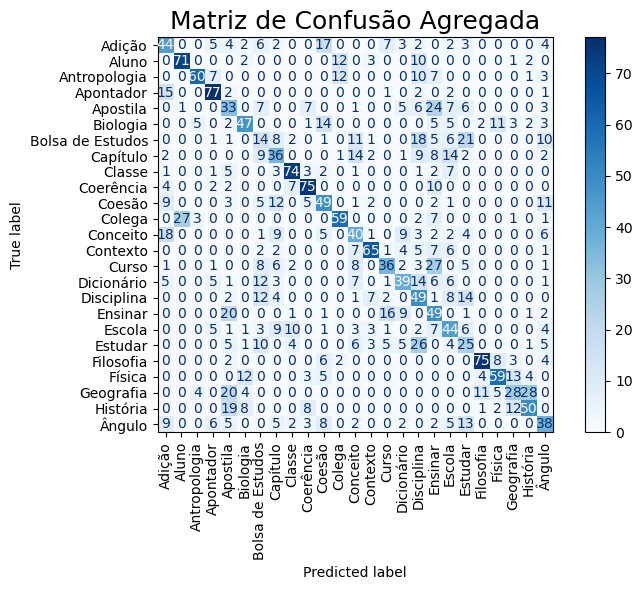

In [74]:
y_true, y_pred, classes = RandomForest(df_teste,random_state,n_splits)
matriz(y_true, y_pred, classes)


Iniciando o treinamento e validação do K-Nearest Neighbors
Executando 10-Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5080 | F1-Score: 0.4771
Fold 2/10 | Teste: Dannubia | Acurácia: 0.5840 | F1-Score: 0.5462
Fold 3/10 | Teste: Alexson | Acurácia: 0.1474 | F1-Score: 0.1235
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1640 | F1-Score: 0.1425
Fold 5/10 | Teste: Dilainne | Acurácia: 0.6640 | F1-Score: 0.6350
Fold 6/10 | Teste: Jackeline | Acurácia: 0.3200 | F1-Score: 0.2973
Fold 7/10 | Teste: Luana | Acurácia: 0.1280 | F1-Score: 0.1119
Fold 8/10 | Teste: Tiago | Acurácia: 0.4120 | F1-Score: 0.3690
Fold 9/10 | Teste: Aparecida | Acurácia: 0.0840 | F1-Score: 0.0487
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5120 | F1-Score: 0.4818

Resultados Finais Agregados do K-Nearest Neighbors:
----------------------------------------------------------------------
Acurácia Média: 0.3523 (+/- 0.2012)
F1-Score Médio: 0.3233 (+/- 0.1978)


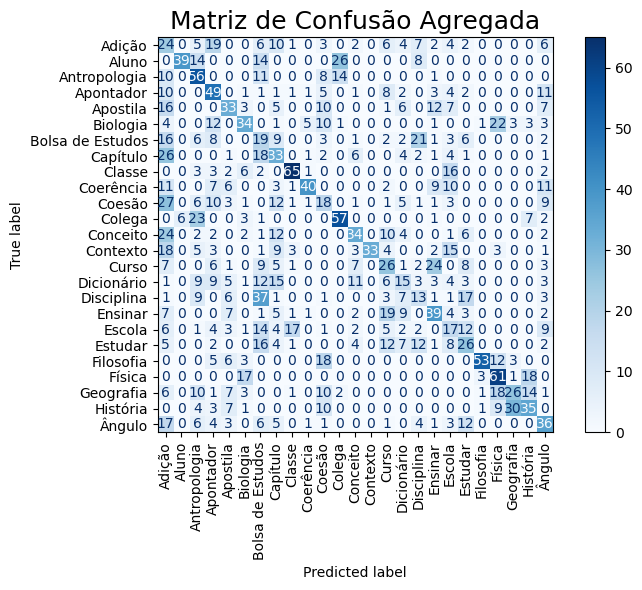

In [107]:
knn_y_true, knn_y_pred, classes = KNN(df_teste, random_state,n_splits)
matriz(knn_y_true, knn_y_pred, classes)


Iniciando o treinamento e validação do Multi-Layer Perceptron (MLP)...
Executando 10-Fold StratifiedGroupKFold...
Fold 1/10 | Teste: Everton | Acurácia: 0.5720 | F1-Score: 0.5370
Fold 2/10 | Teste: Dannubia | Acurácia: 0.7560 | F1-Score: 0.7532
Fold 3/10 | Teste: Alexson | Acurácia: 0.4741 | F1-Score: 0.3976
Fold 4/10 | Teste: Cecilia | Acurácia: 0.1760 | F1-Score: 0.1448
Fold 5/10 | Teste: Dilainne | Acurácia: 0.7680 | F1-Score: 0.7301
Fold 6/10 | Teste: Jackeline | Acurácia: 0.5160 | F1-Score: 0.4883
Fold 7/10 | Teste: Luana | Acurácia: 0.2480 | F1-Score: 0.2144
Fold 8/10 | Teste: Tiago | Acurácia: 0.4840 | F1-Score: 0.4317
Fold 9/10 | Teste: Aparecida | Acurácia: 0.0720 | F1-Score: 0.0545
Fold 10/10 | Teste: Rosenice | Acurácia: 0.5040 | F1-Score: 0.4730

Resultados Finais Agregados do Multi-Layer Perceptron:
----------------------------------------------------------------------
Acurácia Média: 0.4570 (+/- 0.2184)
F1-Score Médio: 0.4225 (+/- 0.2192)


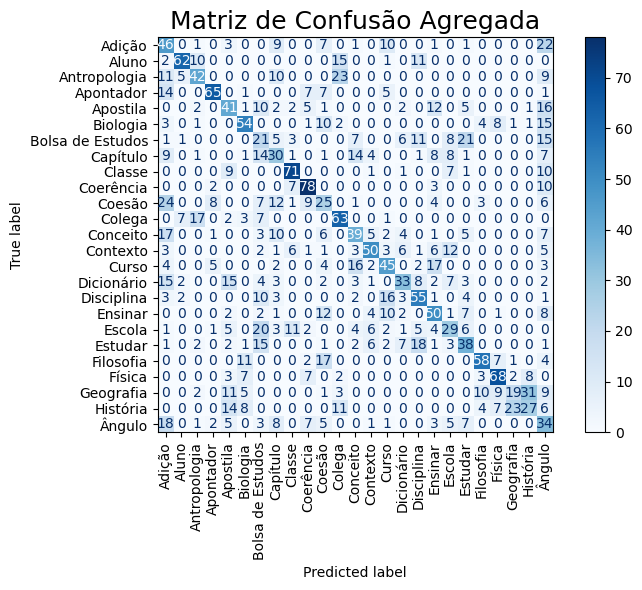

In [84]:
mlp_y_true, mlp_y_pred, classes = MLP(df_teste, random_state, n_splits)
matriz(mlp_y_true, mlp_y_pred, classes)

## Análise dos resultados supervisionados


### RandomForest:

- O RF mostrou o melhor resultado médio na acurácia e f1-score com desvio padrão de 20%, que se deve aos folds que ele teve muito mais dificuldade ao
  ser testado contra eles (Cecilia, Aparecida e Luana)
- A matriz de confusão agregada mostra que embora o modelo tenha aprendido de maneira correta muitos sinais, ele não generalizou todos, provavelmente   sinais semelhantes ou compostos por outro sinal presente na base (Como estudar e bolsa de estudos)

In [89]:
metadados.groupby('interprete')[['width', 'height', 'num_frames']].mean()

,width,height,num_frames
interprete,,,
Alexson,547.059761,749.219124,149.49004
Aparecida,555.576000,780.056000,56.20800
Cecilia,658.015936,864.326693,125.52988
Dannubia,1162.088000,1840.624000,129.08800
Dilainne,1175.536000,1898.304000,132.97600
Everton,680.288000,1011.144000,93.60400
Jackeline,790.336000,1377.032000,111.48400
Luana,297.272000,338.248000,74.20400
Rosenice,542.440000,805.864000,94.75600


- Aparecida é um outlier em número de frames, o que provavelmente explica o mau desempenho do modelo quando esse folder é usado como teste.

- Luana tem abaixo da média e também poucos frames, sendo o segundo pior nesse quesito, o que se refletiu em baixa acurácia.

- O algoritmo mostra-se mais sensível à quantidade de frames do que à resolução, possivelmente por conta da forma como os dados foram selecionados.

- A resolução impacta de forma instável: por exemplo, Cecilia tem número de frames semelhante a Dannubia (que obteve ótima performance), mas ainda assim gerou resultados ruins como folder de teste.

### KNN

- No KNN, embora aparente ter aprendido alguns poucos sinais(classe e colega) ele parece ser o que mais faz "chutes" em relaão aos outros algoritmos
- O KNN é bem sensivel à alta dimensionalidade, embora eu tenha reduzido bastante, as configurações usadas resultaram em 360 colunas, que podem ter resultado na dificuldade em fazer uma boa generalização
- Além disso, como foi visto antes, os interpretes tem caracteristicas bem diferentes, o que dificulda mais ainda seu aprendizado

### MLP

- Comparado ao KNN, o MLP erra menos por "chutes" aleatórios, mesmo quando erra, tende a confundir com classes próximas
- Uma base maior poderia ajudar a melhorar os resultados

# Algoritmos não supervisionados

In [138]:
def Kmeans(clusters, df_X):

    df_X = df_X.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    
    kmeans_classifier = KMeans(
        n_clusters=clusters,
        random_state=random_state,
        n_init=50,
        max_iter=500
    )

    kmeans_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', kmeans_classifier)
    ])
    
    print("\n" + "="*70)
    print("Iniciando Agrupamento K-Means Global")
    print(f"Número de Clusters (K): {clusters}")
    print("="*70)
    
    
    kmeans_pipeline.fit(df_X)
    
    # Gera os rótulos de cluster para todo o conjunto X
    y_pred = kmeans_pipeline.predict(df_X)
    
    # Transformação dos Dados para Avaliação
    
    X_scaled = kmeans_pipeline['scaler'].transform(df_X)
    
    # Avaliação com Métricas Internas de Clustering
    
    # Silhouette Score
    silhouette = silhouette_score(X_scaled, y_pred)
    
    # Davies-Bouldin Score
    davies_bouldin = davies_bouldin_score(X_scaled, y_pred)
    
    # Calinski-Harabasz Score
    calinski_harabasz = calinski_harabasz_score(X_scaled, y_pred)
    
    
    
    print("Avaliação de Qualidade do Agrupamento:")
    print("-" * 50)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
    print("="*50)

    X_pca = PCA(n_components=2).fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    for cluster in np.unique(y_pred):
        plt.scatter(
            X_pca[y_pred == cluster, 0],
            X_pca[y_pred ==cluster, 1],
            label=f'Cluster {cluster}'
            )
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Clusters KMeans ({clusters} clusters)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
    




def Hierarchical(clusters, df_X, vary_linkage=False):
    df_X = df_X.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    
    if vary_linkage:
        LINKAGE_METHODS = ['ward', 'average', 'complete', 'single']
        best_silhouette = -2  # inicializa com valor impossível
        best_linkage_method = None
        results = {}
        
        print("\n" + "="*70)
        print(f"INICIANDO GREED SEARCH DE LINKAGE para K = {clusters}")
        print("-" * 70)
        
        for linkage_method in LINKAGE_METHODS:
            
            hierarchical_classifier = AgglomerativeClustering(
                n_clusters=clusters,
                linkage=linkage_method,
                metric='euclidean'
            )

            # Define o Pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('h_cluster', hierarchical_classifier)
            ])
            
            # Treinamento e Predição
            pipeline.fit(df_X)
            y_pred = pipeline['h_cluster'].labels_
            
            X_scaled = pipeline['scaler'].transform(df_X)

            # Cálculo das métricas
            try:
                silhouette = silhouette_score(X_scaled, y_pred)
                davies_bouldin = davies_bouldin_score(X_scaled, y_pred)
                calinski_harabasz = calinski_harabasz_score(X_scaled, y_pred)
                
                results[linkage_method] = {
                    'Silhouette': silhouette,
                    'Davies-Bouldin': davies_bouldin,
                    'Calinski-Harabasz': calinski_harabasz
                }

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_linkage_method = linkage_method

                print(f"[{linkage_method.upper()}]: Silhouette: {silhouette:.4f} | Davies-Bouldin: {davies_bouldin:.4f} | Calinski-Harabasz: {calinski_harabasz:.4f} \n")
                X_pca = PCA(n_components=2).fit_transform(X_scaled)
                plt.figure(figsize=(6,4))
                for cluster in np.unique(y_pred):
                    plt.scatter(
                        X_pca[y_pred == cluster, 0],
                        X_pca[y_pred ==cluster, 1],
                        label=f'Cluster {cluster}'
                        )
                plt.xlabel('Feature 1')
                plt.ylabel('Feature 2')
                plt.title(f'Clusters Hierárquico - {linkage_method} ({clusters} clusters)')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)
                plt.show()
            except ValueError as e:
                # Caso o clustering falhe (ex: single cluster), apenas informa
                print(f"[{linkage_method.upper()}]: FALHOU. Erro: {e}")
                         
    # vary_linkage = False

    else:        
        hierarchical_classifier = AgglomerativeClustering(
            n_clusters=clusters,
            metric='euclidean'
        )
        hierarchical_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('h_cluster', hierarchical_classifier)
        ])
        
        print("\n" + "="*70)
        print("Iniciando Agrupamento Hierárquico Global")
        print(f"Número de Clusters (K): {clusters}")
        print("="*70)
        
        hierarchical_pipeline.fit(df_X)
        
        # Gera os rótulos de cluster para todo o conjunto X
        y_pred = hierarchical_pipeline['h_cluster'].labels_
        
        # Transformação dos Dados para Avaliação
        X_scaled = hierarchical_pipeline['scaler'].transform(df_X)
        
        # Cálculo das Métricas
        silhouette = silhouette_score(X_scaled, y_pred)
        davies_bouldin = davies_bouldin_score(X_scaled, y_pred)
        calinski_harabasz = calinski_harabasz_score(X_scaled, y_pred)
        
        
        print("Avaliação de Qualidade do Agrupamento:")
        print("-" * 50)
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
        print("="*50)

        X_pca = PCA(n_components=2).fit_transform(X_scaled)
        plt.figure(figsize=(8,6))
        for cluster in np.unique(y_pred):
            plt.scatter(
                X_pca[y_pred == cluster, 0],
                X_pca[y_pred ==cluster, 1],
                label=f'Cluster {cluster}'
                )
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'Clusters Hierárquico ({clusters} clusters)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

### K-means


Iniciando Agrupamento K-Means Global
Número de Clusters (K): 25
Avaliação de Qualidade do Agrupamento:
--------------------------------------------------
Silhouette Score: 0.1406
Davies-Bouldin Score: 1.8845
Calinski-Harabasz Score: 163.9327


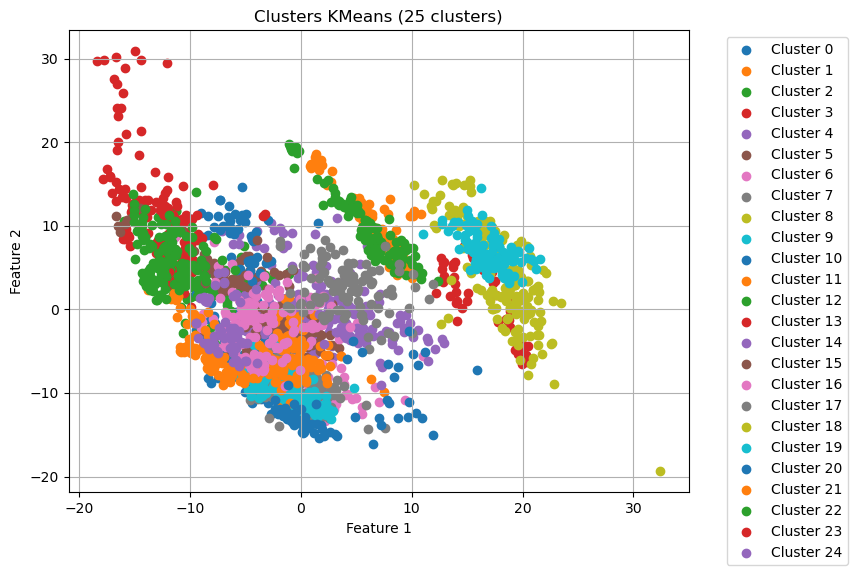

In [122]:
Kmeans(25,df_teste)

### Hierárquico


Iniciando Agrupamento Hierárquico Global
Número de Clusters (K): 25
Avaliação de Qualidade do Agrupamento:
--------------------------------------------------
Silhouette Score: 0.1293
Davies-Bouldin Score: 1.9031
Calinski-Harabasz Score: 149.9001


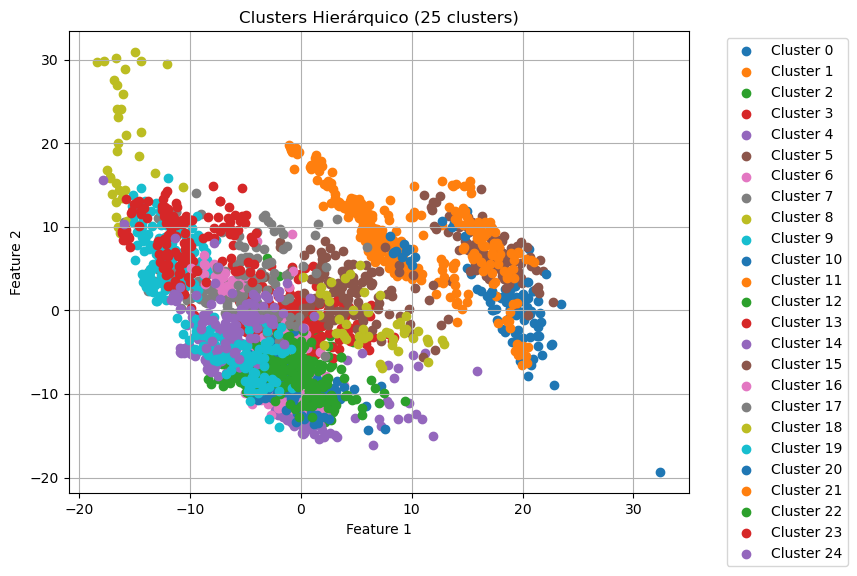

In [124]:
Hierarchical(25,df_teste)

## Teste do cotovelo


Iniciando o Teste do Cotovelo
Testando K de 1 a 29 clusters
K=1 concluído. WCSS: 900360.00
K=2 concluído. WCSS: 777067.55
K=3 concluído. WCSS: 643774.68
K=4 concluído. WCSS: 602155.94
K=5 concluído. WCSS: 563860.74
K=6 concluído. WCSS: 537818.59
K=7 concluído. WCSS: 525190.90
K=8 concluído. WCSS: 516719.30
K=9 concluído. WCSS: 495911.32
K=10 concluído. WCSS: 476827.99
K=11 concluído. WCSS: 462281.19
K=12 concluído. WCSS: 457222.02
K=13 concluído. WCSS: 441532.69
K=14 concluído. WCSS: 429496.56
K=15 concluído. WCSS: 419161.01
K=16 concluído. WCSS: 414307.40
K=17 concluído. WCSS: 405547.22
K=18 concluído. WCSS: 398818.59
K=19 concluído. WCSS: 393742.52
K=20 concluído. WCSS: 388752.39
K=21 concluído. WCSS: 373777.55
K=22 concluído. WCSS: 371100.15
K=23 concluído. WCSS: 367262.99
K=24 concluído. WCSS: 358342.72
K=25 concluído. WCSS: 353237.33
K=26 concluído. WCSS: 348082.28
K=27 concluído. WCSS: 344781.94
K=28 concluído. WCSS: 339201.01
K=29 concluído. WCSS: 333672.70

Gerando Gráfico do 

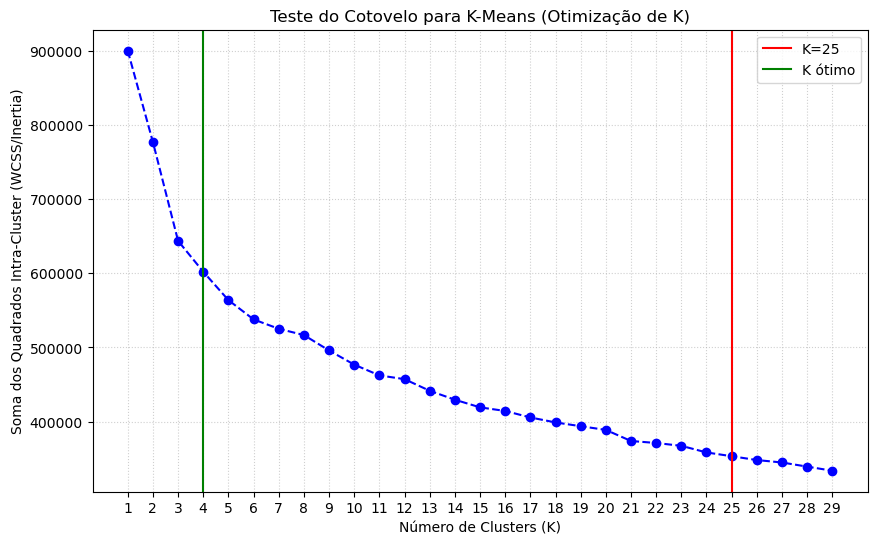

In [155]:
K_RANGE = range(1, 30) 
wcss = []              

print("\n" + "="*70)
print("Iniciando o Teste do Cotovelo")
print(f"Testando K de 1 a {max(K_RANGE)} clusters")
print("="*70)

# 1. Iterar sobre o intervalo de K
for k in K_RANGE:
    # O K-Means precisa ser redefinido em cada iteração com o novo K
    kmeans_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(
            n_clusters=k,        
            random_state=random_state,
            n_init='auto',
            max_iter=300
        ))
    ])
    X = df_teste.drop(columns=['sinal', 'interprete' , 'file_name'], errors='ignore')
    kmeans_pipeline.fit(X)
    wcss.append(kmeans_pipeline['kmeans'].inertia_)
    
    print(f"K={k} concluído. WCSS: {wcss[-1]:.2f}")


print("\n" + "="*70)
print("Gerando Gráfico do Cotovelo...")
print("="*70)

plt.figure(figsize=(10, 6))
plt.plot(K_RANGE, wcss, marker='o', linestyle='--', color='blue')
plt.title('Teste do Cotovelo para K-Means (Otimização de K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Soma dos Quadrados Intra-Cluster (WCSS/Inertia)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(K_RANGE)
plt.axvline(x=25, color='red', linestyle='-', label='K=25')
plt.axvline(x=4, color='green', linestyle='-', label = 'K ótimo')
plt.legend()
plt.show()

## Usando K = 4 pelo teste do cotovelo


Iniciando Agrupamento K-Means Global
Número de Clusters (K): 4
Avaliação de Qualidade do Agrupamento:
--------------------------------------------------
Silhouette Score: 0.1425
Davies-Bouldin Score: 2.1212
Calinski-Harabasz Score: 416.1511


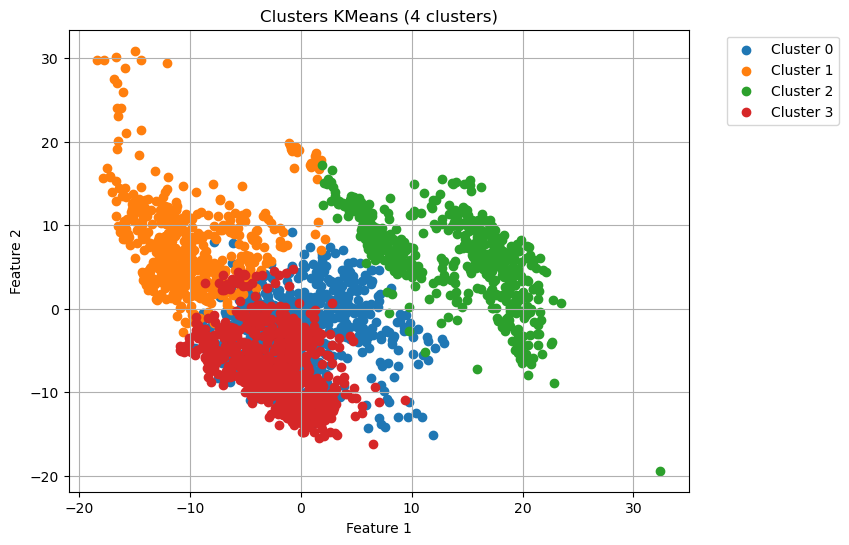

In [148]:
Kmeans(4,df_teste)


Iniciando Agrupamento Hierárquico Global
Número de Clusters (K): 4
Avaliação de Qualidade do Agrupamento:
--------------------------------------------------
Silhouette Score: 0.1709
Davies-Bouldin Score: 1.8710
Calinski-Harabasz Score: 378.4186


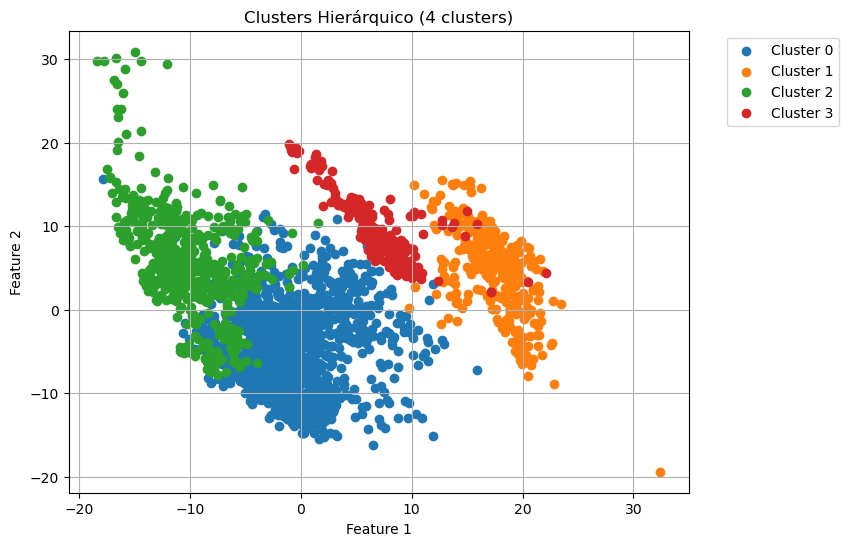

In [150]:
Hierarchical(4,df_teste)

### Análise

- Sem o teste do cotovelo e usando k = 25(número de sinais diferentes) podemos ver uma grande sobreposição e alta granularidade, já é esperado
- Com K=4 podemos notar uma redução ótima em relação a sobreposição e clusterização, tem mais lógica no que é visto
- Embora tenha poucas diferenças entre os dois, o Hierárquico parece ter definido os grupos um pouco melhor

## Variando o linkage


INICIANDO GREED SEARCH DE LINKAGE para K = 4
----------------------------------------------------------------------
[WARD]: Silhouette: 0.1709 | Davies-Bouldin: 1.8710 | Calinski-Harabasz: 378.4186 



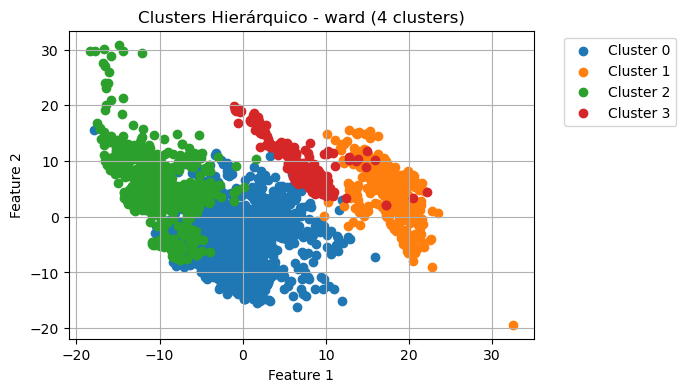

[AVERAGE]: Silhouette: 0.2004 | Davies-Bouldin: 0.7992 | Calinski-Harabasz: 34.3129 



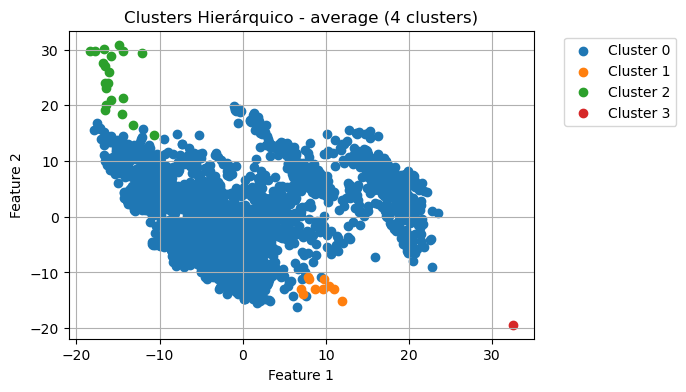

[COMPLETE]: Silhouette: 0.0962 | Davies-Bouldin: 2.0298 | Calinski-Harabasz: 92.0428 



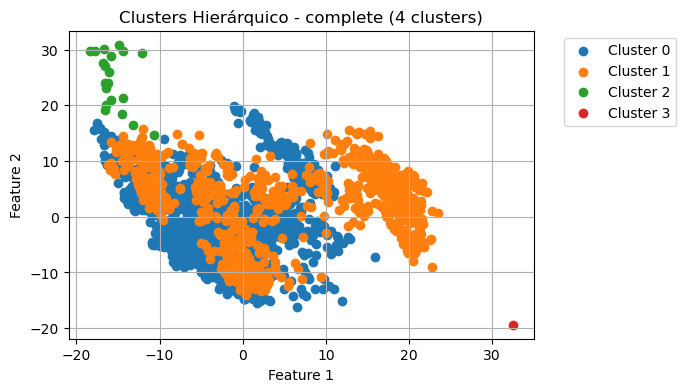

[SINGLE]: Silhouette: 0.1189 | Davies-Bouldin: 0.5997 | Calinski-Harabasz: 7.2070 



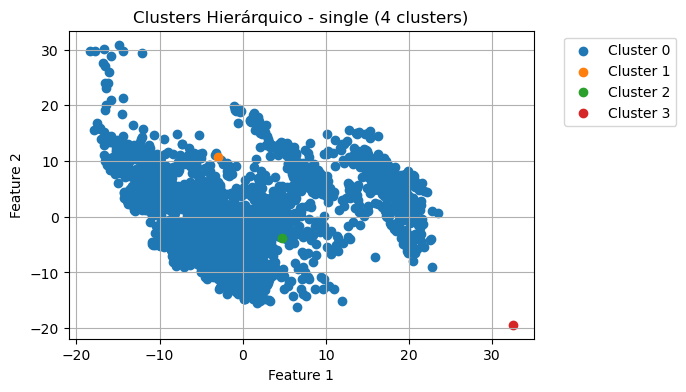

In [152]:
Hierarchical(4,df_teste,True)

### Análise Ward vs Avarage

- Embora tenha Silhouette e Davies-Bouldin um pouco melhores, o Avarage obtém esse resultado pois tem o cluster de cor azul como predominante, isso se mostra quando analisamos a Calinski-Harabasz, com um valor bem abaixo comparado ao Ward e até ao K-Means
- O Ward se mostra mais coeso e com grupos com maior possibilidade de usabilidade